In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr

DPI = 75
CMAP = "plasma"
plt.rcParams["figure.figsize"] = (20, 9)
plt.style.use("default_light")

DATA = "data/fig5-thalamus_input_bifurcation"

In [2]:
spindles = pd.read_csv(os.path.join(DATA, "spindles_detection_trn_thresh.csv"))
spindles = spindles.set_index(["g_LK", "g_h", "tcr_noise", "stim"])
# count number of spindles simply as number of rows for each multiindex
count_series = spindles.groupby(level=spindles.index.names).count()["Start"]
spindles_xr = xr.DataArray.from_series(count_series)
spindles_xr.name = "EEG-algo"
spindles_xr["g_LK"] = np.around(spindles_xr["g_LK"], 4)
spindles_xr["g_h"] = np.around(spindles_xr["g_h"], 4)

In [3]:
# no spindles for high g_LK, so manually add to get nice figs
coords = {
    "g_LK": list(set(spindles_xr["g_h"].values) - set(spindles_xr["g_LK"].values)),
    "g_h": spindles_xr["g_h"].values,
    "tcr_noise": spindles_xr["tcr_noise"].values,
}
dims = coords.keys()
add_df = xr.DataArray(0.0, dims=dims, coords=coords)
spindles_xr = xr.concat([add_df, spindles_xr], dim="g_LK").sortby("g_LK")

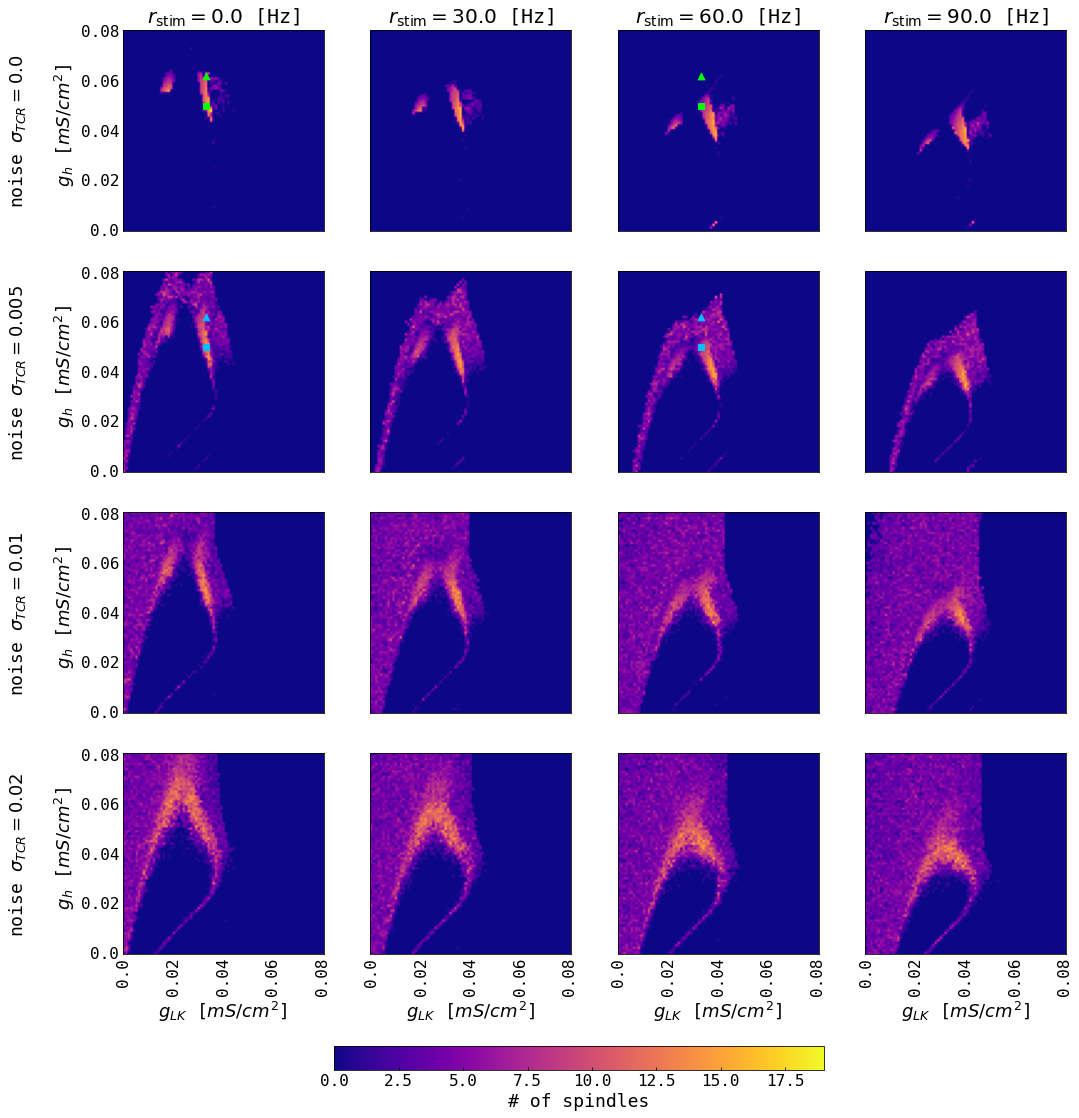

In [40]:
duration = 1.
mini = np.nanmin(spindles_xr.values) / duration
maxi = np.nanmax(spindles_xr.values) / duration
TICK_EVERY = 20

# MARKERS
mark_glk = 0.033
mark_gh1 = 0.062
mark_gh2 = 0.05
MARKER_SIZE = 45

fig, axs = plt.subplots(
    nrows=len(spindles_xr["tcr_noise"]),
    ncols=len(spindles_xr["stim"]),
    sharex=True,
    sharey=True,
    figsize=(17, 17)
)
for i, noise in enumerate(spindles_xr["tcr_noise"]):
    for j, stim in enumerate(spindles_xr["stim"]):
        ax = axs[i, j]
        f = spindles_xr.sel({"tcr_noise": noise.values, "stim": stim.values}).values
        f[np.isnan(f)] = 0.0
        ax.imshow(f.T / duration, cmap=CMAP, origin="lower", vmin=mini, vmax=maxi)
        if (stim.values == 0.0 or stim.values == 0.06) and noise.values == 0.0:
            x = int((mark_glk / spindles_xr["g_LK"].max()).values * len(spindles_xr["g_LK"]))
            y = int((mark_gh1 / spindles_xr["g_h"].max()).values * len(spindles_xr["g_h"]))
            ax.scatter(x, y, c="lime", s=MARKER_SIZE, marker="^")
            x = int((mark_glk / spindles_xr["g_LK"].max()).values * len(spindles_xr["g_LK"]))
            y = int((mark_gh2 / spindles_xr["g_h"].max()).values * len(spindles_xr["g_h"]))
            ax.scatter(x, y, c="lime", s=MARKER_SIZE, marker="s")
        if (stim.values == 0.0 or stim.values == 0.06) and noise.values == 0.005:
            x = int((mark_glk / spindles_xr["g_LK"].max()).values * len(spindles_xr["g_LK"]))
            y = int((mark_gh1 / spindles_xr["g_h"].max()).values * len(spindles_xr["g_h"]))
            ax.scatter(x, y, c="deepskyblue", s=MARKER_SIZE, marker="^")
            x = int((mark_glk / spindles_xr["g_LK"].max()).values * len(spindles_xr["g_LK"]))
            y = int((mark_gh2 / spindles_xr["g_h"].max()).values * len(spindles_xr["g_h"]))
            ax.scatter(x, y, c="deepskyblue", s=MARKER_SIZE, marker="s")
        if j == 0:
            ax.set_yticks(np.arange(len(spindles_xr["g_h"]))[::TICK_EVERY])
            ax.set_yticklabels([gh.values for gh in spindles_xr["g_h"]][::TICK_EVERY])
            ax.set_ylabel(f"noise $\sigma_{{TCR}}={noise.values}$ \n\n $g_{{h}}$ [$mS/cm^2$]")
        if i == len(spindles_xr["tcr_noise"]) - 1:
            ax.set_xticks(np.arange(len(spindles_xr["g_LK"]))[::TICK_EVERY])
            ax.set_xticklabels(
                [gh.values for gh in spindles_xr["g_LK"]][::TICK_EVERY], rotation=90
            )
            ax.set_xlabel("$g_{LK}$ [$mS/cm^2$]")
        if i == 0:
            ax.set_title(f"$r_{{\mathrm{{stim}}}}={stim.values * 1000.}$ [Hz]")
cbar_ax = fig.add_axes([0.3, 0.03, 0.4, 0.02])
cbar = mpl.colorbar.ColorbarBase(
    cbar_ax,
    cmap=plt.get_cmap(CMAP),
    norm=mpl.colors.Normalize(vmin=mini, vmax=maxi),
    orientation="horizontal",
)
cbar.set_label("# of spindles")
# plt.tight_layout()
# to PDF due transparency
plt.savefig(
    "../figs/thalamus_stim_bifurcation.pdf", dpi=DPI, transparent=True, bbox_inches="tight"
)